In [1]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple
NBCHAINS = 10
DELTA = 4
NCR = 3
NBITERMCMC = 35
NBBURNING = 20
DEBUGRUB = 2. # Gelman Rubin criteria
NBCELLS = 40

dH : [(Timestamp('2016-06-28 06:45:00'), (0.8455651738980304, 287.16499999999996)), (Timestamp('2016-06-28 07:00:00'), (0.845598722046913, 287.159)), (Timestamp('2016-06-28 07:15:00'), (0.84563866885015, 287.15799999999996)), (Timestamp('2016-06-28 07:30:00'), (0.8456745294855709, 287.15599999999995)), (Timestamp('2016-06-28 07:45:00'), (0.8457087531923185, 287.15599999999995)), (Timestamp('2016-06-28 08:00:00'), (0.8457346869561947, 287.15599999999995)), (Timestamp('2016-06-28 08:15:00'), (0.8457538391584245, 287.161)), (Timestamp('2016-06-28 08:30:00'), (0.8457628039753982, 287.167)), (Timestamp('2016-06-28 08:45:00'), (0.8457635267129118, 287.174)), (Timestamp('2016-06-28 09:00:00'), (0.8457572935292086, 287.179)), (Timestamp('2016-06-28 09:15:00'), (0.8457517700915217, 287.185)), (Timestamp('2016-06-28 09:30:00'), (0.8457492408521055, 287.19399999999996)), (Timestamp('2016-06-28 09:45:00'), (0.8457605113179875, 287.21799999999996)), (Timestamp('2016-06-28 10:00:00'), (0.84577645940

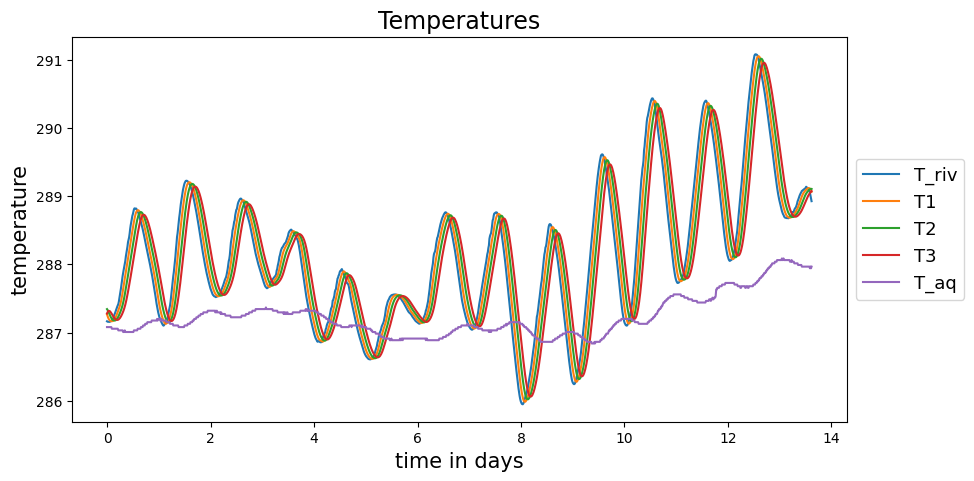

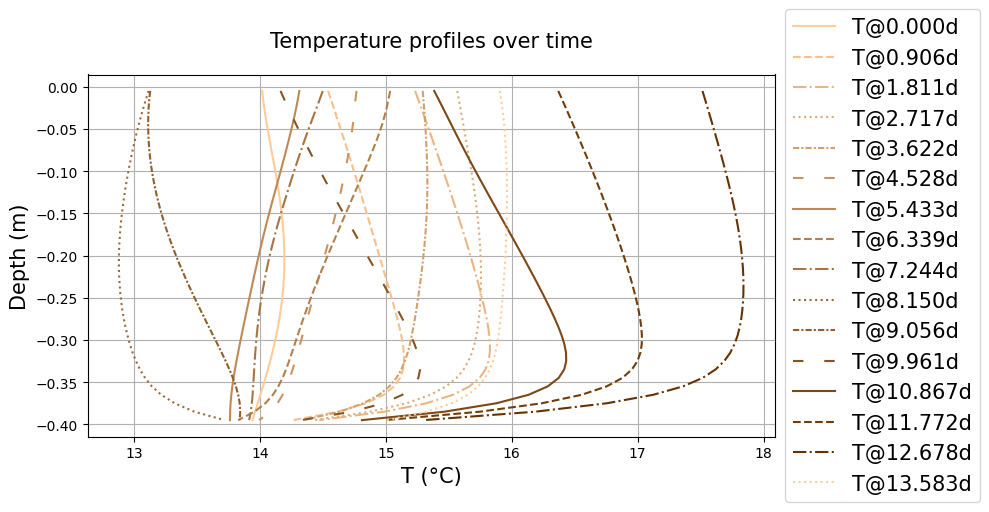

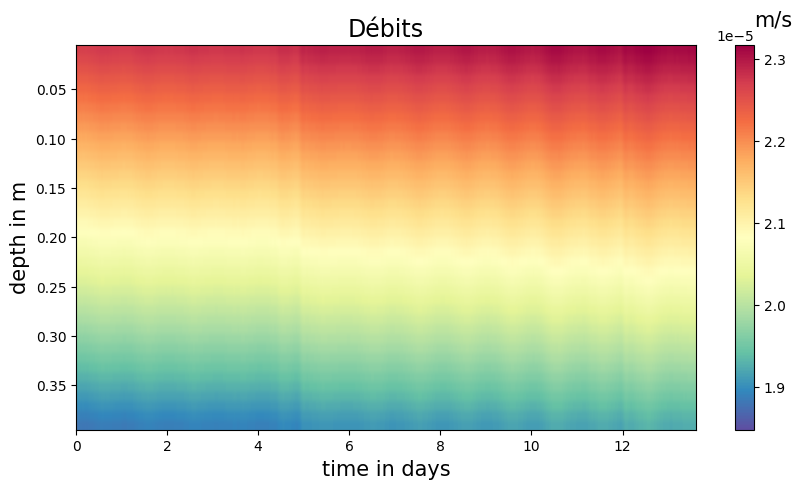

In [2]:
capteur_riviere = pd.read_csv("./data/Point034_processed/processed_pressures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv("./data/Point034_processed/processed_temperatures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("./configuration/pressure_sensors/P508.csv")

def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a

# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + ZERO_CELSIUS
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + ZERO_CELSIUS
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + ZERO_CELSIUS
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + ZERO_CELSIUS
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + ZERO_CELSIUS

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

print(f"dH : {dH_measures}")
print(f"Tshaft : {T_measures}")


Zbottom = 0.4

col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, Zbottom],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange',
    "nb_cells": NBCELLS,
}

col = Column.from_dict(col_dict)

Layer_homogenous = {
    "name": "Layer_homogenous",
    "zLow": Zbottom,
    "moinslog10IntrinK": 12,
    "n": .1,
    "lambda_s": 2,
    "rhos_cs": 4e6,
    "q": 1e-5
}

Layer_homogenous = Layer.from_dict(Layer_homogenous)

col.set_layers(Layer_homogenous)


col.compute_solve_transi(verbose=True)


col.plot_temperature_at_sensors()

nt = len(col._temperatures[0,:])
dplot=15
col.plot_temperatures_umbrella(round(nt/dplot))

flows = col.get_flows_solve()
unitLeg="m/s"
title="Débits"
col.plot_it_Zt(flows,title,unitLeg,1.04,2)